In [6]:
using Flux
using Flux.Optimise: update!
using MLDatasets
using Flux: Chain, Dense, onecold, logitcrossentropy, @epochs
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
# Get MNIST data
xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
xtest, ytest = MLDatasets.MNIST.testdata(Float32)

# Reshape Data for flatten the each image into linear array
xtrain = Flux.flatten(xtrain)
xtest = Flux.flatten(xtest)

# One-hot-encode the labels
ytrain, ytest = Flux.onehotbatch(ytrain, 0:9), Flux.onehotbatch(ytest, 0:9)

function getbatcheddata(xtrain,ytrain,xtest,ytest)
    train_data = Flux.Data.DataLoader(xtrain,ytrain,batchsize=1024,shuffle=true)
    test_data = Flux.Data.DataLoader(xtest,ytest,batchsize=1024)
    return train_data, test_data
end

# Loss function for minibatch
function loss_all(data,model)
    l = 0f0
    for (x,y) in data
        l += logitcrossentropy(model(x),y) # calculate loss and sum
    end
    l/length(data) # return length-normalised loss
end

# Accuracy function
function accuracy(data,model)
    acc = 0
    for (x,y) in data
        acc += sum(onecold(model(x)) .== onecold(y))*1 / size(x,2)
    end
    acc/length(data)
end

accuracy (generic function with 1 method)

In [3]:
# Build model
imgsize=(28,28,1)
nclasses=10
m = Chain(Dense(prod(imgsize),32,relu), Dense(32,nclasses))

train_data, test_data = getbatcheddata(xtrain,ytrain,xtest,ytest) # Data is now mini-batched ready for training
loss(x,y) = logitcrossentropy(m(x),y) # loss for individual x,y pair
ps = Flux.params(m)

opt = ADAM(3e-4)

ADAM(0.0003, (0.9, 0.999), IdDict{Any,Any}())

In [4]:
# Either use built-in train function
iter = 0
cb2 = function ()
    global iter +=1
    if iter%20 == 0
        @show (loss_all(train_data,m), accuracy(train_data,m))
    end
end
loss_all(train_data,m) # Show initial loss
@epochs 2 Flux.train!(loss,ps, train_data, opt; cb = cb2) # Train! loops over 2 epochs using macro

┌ Info: Epoch 1
└ @ Main /home/nadanai/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121


(loss_all(train_data, m), accuracy(train_data, m)) = (2.0690076f0, 0.2931821824821588)
(loss_all(train_data, m), accuracy(train_data, m)) = (1.7870922f0, 0.5037154674955397)


┌ Info: Epoch 2
└ @ Main /home/nadanai/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121


(loss_all(train_data, m), accuracy(train_data, m)) = (1.4824492f0, 0.6518846523751116)
(loss_all(train_data, m), accuracy(train_data, m)) = (1.2196748f0, 0.7456956330842998)
(loss_all(train_data, m), accuracy(train_data, m)) = (1.016813f0, 0.7936848377564675)


In [5]:
# Or use custom train loop

function my_custom_train!(loss,ps,data,opt)
    local training_loss#
    iter = 0
    for d in data # Train for one epoch
        iter+=1
        gs = gradient(ps) do
            training_loss = loss(d...)
            return training_loss
        end
#        @show iter, training_loss
        update!(opt,ps,gs)
    end
    return loss_all(train_data,m), accuracy(train_data,m)
end

# Then train for multiple epochs
num_epochs = 10
for i in 1:num_epochs
    ls,ac = my_custom_train!(loss,ps,train_data,opt)
    @show ls,ac
end

(ls, ac) = (0.6317831f0, 0.8568721774643177)
(ls, ac) = (0.51444775f0, 0.8763529005909901)
(ls, ac) = (0.4486862f0, 0.8870811496431757)
(ls, ac) = (0.40665758f0, 0.89658804220562)
(ls, ac) = (0.37745816f0, 0.9013096914027654)
(ls, ac) = (0.35542804f0, 0.9063963537020517)
(ls, ac) = (0.3379923f0, 0.9092249874553969)
(ls, ac) = (0.3241243f0, 0.9113410180642284)
(ls, ac) = (0.3128132f0, 0.9144884938113291)
(ls, ac) = (0.3029168f0, 0.916959954839429)


predict = onecold(m(example)) - 1 = 7


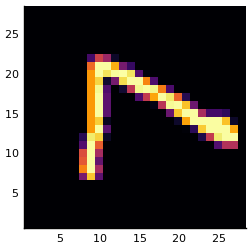

In [16]:
# Make prediction
example = xtest[:,1]
@show predict = (onecold(m(example))-1)
img = reshape(example,(28,28))
fig = plot(size=(250,250))
heatmap!(img,aspect_ratio=:equal,cb=:false)

In [ ]:
# Test accuracy
accuracy(test_data,m)